**Linking Writing Processes to Writing Quality**

train_logs.csv - Input logs to be used as training data. To prevent reproduction of the essay text, all alphanumeric character inputs have been replaced with the "anonymous" character q; punctuation and other special characters have not been anonymized.

id - The unique ID of the essay

event_id - The index of the event, ordered chronologically

down_time - The time of the down event in milliseconds

up_time - The time of the up event in milliseconds

action_time - The duration of the event (the difference between down_time and up_time)

activity - The category of activity which the event belongs to

Nonproduction - The event does not alter the text in any way

Input - The event adds text to the essay

Remove/Cut - The event removes text from the essay

Paste - The event changes the text through a paste input

Replace - The event replaces a section of text with another string

Move From [x1, y1] To [x2, y2] - The event moves a section of text spanning character index x1, y1 to a new location x2, y2

down_event - The name of the event when the key/mouse is pressed

up_event - The name of the event when the key/mouse is released

text_change - The text that changed as a result of the event (if any)

cursor_position - The character index of the text cursor after the event

word_count - The word count of the essay after the event

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [67]:
# Load the data
train_logs = pd.read_csv('/content/drive/MyDrive/475/475data/train_logs.csv')

print("Train Logs:")
print(train_logs.head())
print(train_logs.info())

Train Logs:
         id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0           0  
2      Shift      Shift    NoChange                0           0  
3          q          q           q                1           1  
4          q          q           q                2           1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405898 entries, 0 to 8405897
Data columns (total 11 columns):
 #   Column           Dtype 
---  

Example: List id = 001519c8

In [68]:
# Filter where the 'id' is '001519c8'
id_001519c8 = train_logs[train_logs['id'] == '001519c8']

# Print the filtered 'id' is '001519c8'
print(id_001519c8)

            id  event_id  down_time  up_time  action_time       activity  \
0     001519c8         1       4526     4557           31  Nonproduction   
1     001519c8         2       4558     4962          404  Nonproduction   
2     001519c8         3     106571   106571            0  Nonproduction   
3     001519c8         4     106686   106777           91          Input   
4     001519c8         5     107196   107323          127          Input   
...        ...       ...        ...      ...          ...            ...   
2552  001519c8      2553    1781786  1781841           55     Remove/Cut   
2553  001519c8      2554    1781917  1781991           74     Remove/Cut   
2554  001519c8      2555    1782062  1782141           79     Remove/Cut   
2555  001519c8      2556    1782922  1782985           63          Input   
2556  001519c8      2557    1801877  1801969           92  Nonproduction   

     down_event   up_event text_change  cursor_position  word_count  
0     Leftclick  

Read train scores and visualize groups of each score.

In [69]:
# Load the train scores data
train_scores = pd.read_csv('/content/drive/MyDrive/475/475data/train_scores.csv')

print("Train Scores:")
print(train_scores)

Train Scores:
            id  score
0     001519c8    3.5
1     0022f953    3.5
2     0042269b    6.0
3     0059420b    2.0
4     0075873a    4.0
...        ...    ...
2466  ffb8c745    3.5
2467  ffbef7e5    4.0
2468  ffccd6fd    1.5
2469  ffec5b38    5.0
2470  fff05981    4.0

[2471 rows x 2 columns]


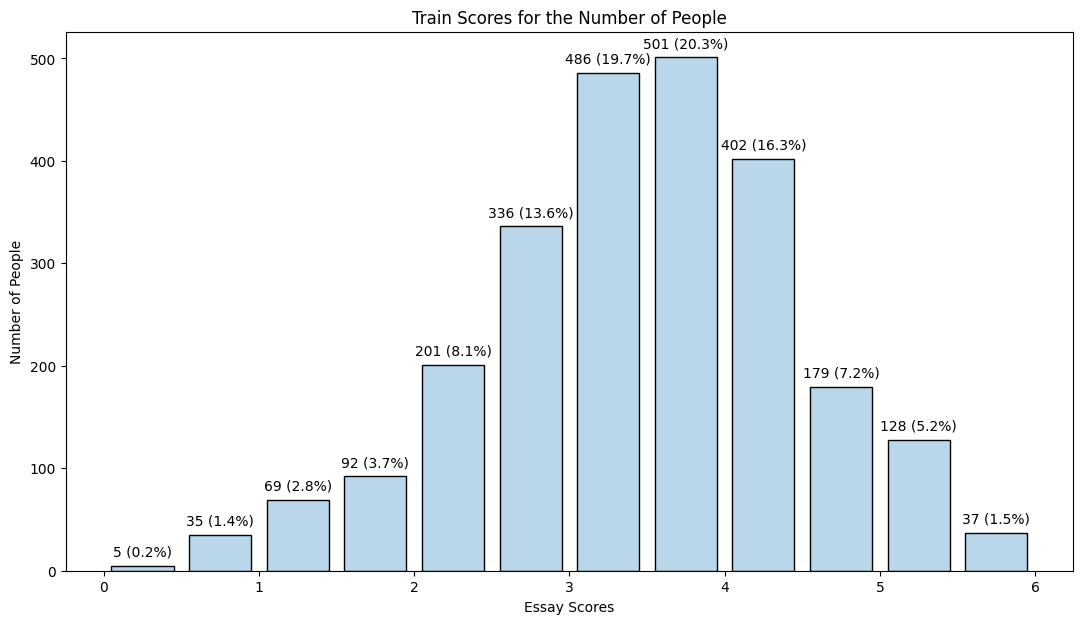

In [70]:
# Plotting the bars of train scores
train_scores = pd.DataFrame(train_scores)
# Using groupby
group_scores = train_scores.groupby('score').size().reset_index(name='count')
scores = group_scores['score']
score_counts = group_scores['count']
# Range
bin_edges = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]
bin_counts = [train_scores[(train_scores['score'] > bin_edges[i]) & (train_scores['score'] <= bin_edges[i+1])].count()[0] for i in range(len(bin_edges)-1)]
bar_positions = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]


plt.figure(figsize=(13, 7))
# Design bars color
bars = plt.bar(bar_positions, bin_counts, width=0.4, align='center', color=sns.color_palette("Blues")[1], edgecolor='black')

# Display count above the bars
total_scores = sum(score_counts)
for bar, count in zip(bars, score_counts):
  # Displaying numbers and percentages
  train_percentage = f'{100 * count / total_scores:.1f}%'
  plt.annotate(f'{int(count)} ({train_percentage})', xy=(bar.get_x() + bar.get_width() / 2, count),
    xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

# Setting the plot title and axis labels
plt.title('Train Scores for the Number of People')
plt.xlabel('Essay Scores')
plt.ylabel('Number of People')

# Displaying the plot
plt.show()

In [71]:
# Merge train_logs and train_scores, using the 'id' column as a key.
merged_data = train_logs.merge(train_scores, on='id')

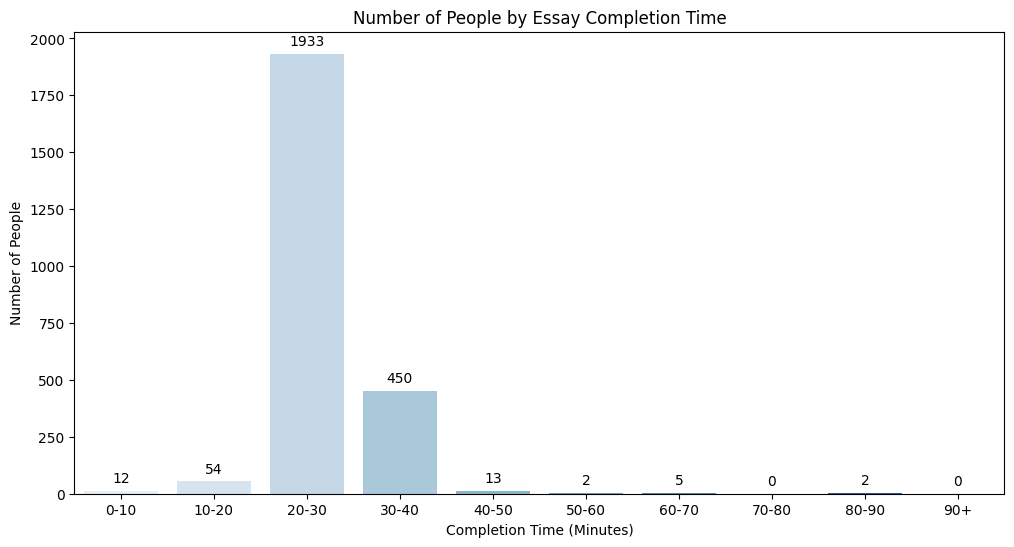

In [72]:
# Grouping data by 'id', calculating first down_time and last up_time
first_down_time = merged_data.groupby('id')['down_time'].min()
last_up_time = merged_data.groupby('id')['up_time'].max()

# Calculating completion time for each essay in minutes, convert from ms to minutes
completion_time = (last_up_time - first_down_time) / 60000

# Create a DataFrame for completion_time with 'id' as the index
time = pd.DataFrame(completion_time).reset_index()
time.columns = ['id', 'completion_time']

# Time range is [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, float('inf')]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90+']
time['time_category'] = pd.cut(time['completion_time'], bins=bins, labels=labels)

# Counting the number of ids in each time category
people_counts = time.groupby('time_category')['id'].nunique()

# Creating the bar plot
plt.figure(figsize=(12, 6))
bars = sns.barplot(x=people_counts.index, y=people_counts.values, palette=sns.color_palette("Blues", len(people_counts)))

# Displaying numbers on top of the bars
for bar in bars.patches:
  bars.annotate(format(int(bar.get_height())), (bar.get_x() + bar.get_width() / 2., bar.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# Setting the plot
plt.title('Number of People by Essay Completion Time')
plt.xlabel('Completion Time (Minutes)')
plt.ylabel('Number of People')

# Displaying the plot
plt.show()

In [73]:
for interval, count in people_counts.items():
  print(f"{interval}: {count} people")

0-10: 12 people
10-20: 54 people
20-30: 1933 people
30-40: 450 people
40-50: 13 people
50-60: 2 people
60-70: 5 people
70-80: 0 people
80-90: 2 people
90+: 0 people


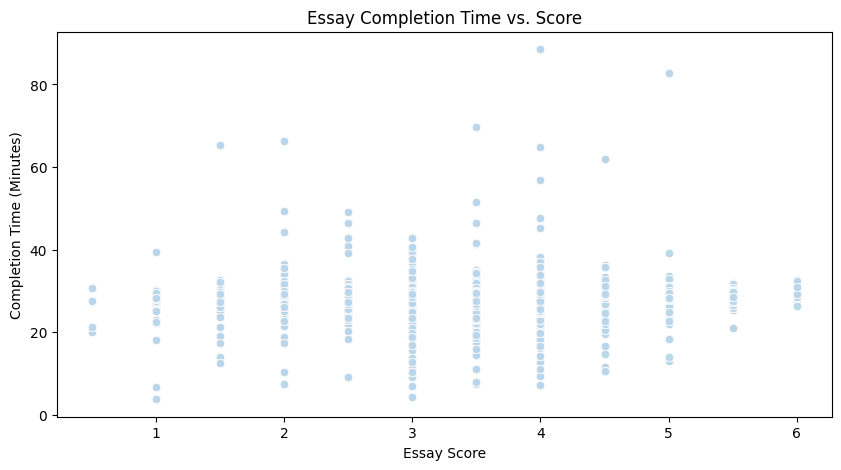

In [74]:
# Plot Essay completion and scores relationship
merged_data = merged_data.assign(completion_time=merged_data['id'].map(completion_time))

# # Creating a scatter plot to visualize the completion time and scores
plt.figure(figsize=(10, 5))
sns.scatterplot(x='score', y='completion_time', data=merged_data, color=sns.color_palette("Blues")[1])

plt.title('Essay Completion Time vs. Score')
plt.xlabel('Essay Score')
plt.ylabel('Completion Time (Minutes)')

plt.show()

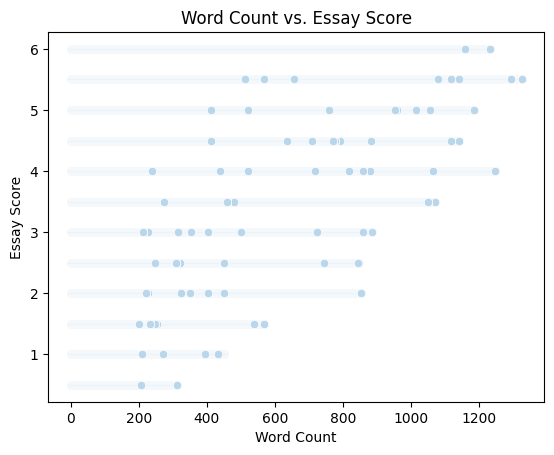

In [75]:
# Plot word count and essay score.
sns.scatterplot(x='word_count', y='score', data=merged_data, color=sns.color_palette("Blues")[1])

plt.title('Word Count vs. Essay Score')
plt.xlabel('Word Count')
plt.ylabel('Essay Score')

plt.show()

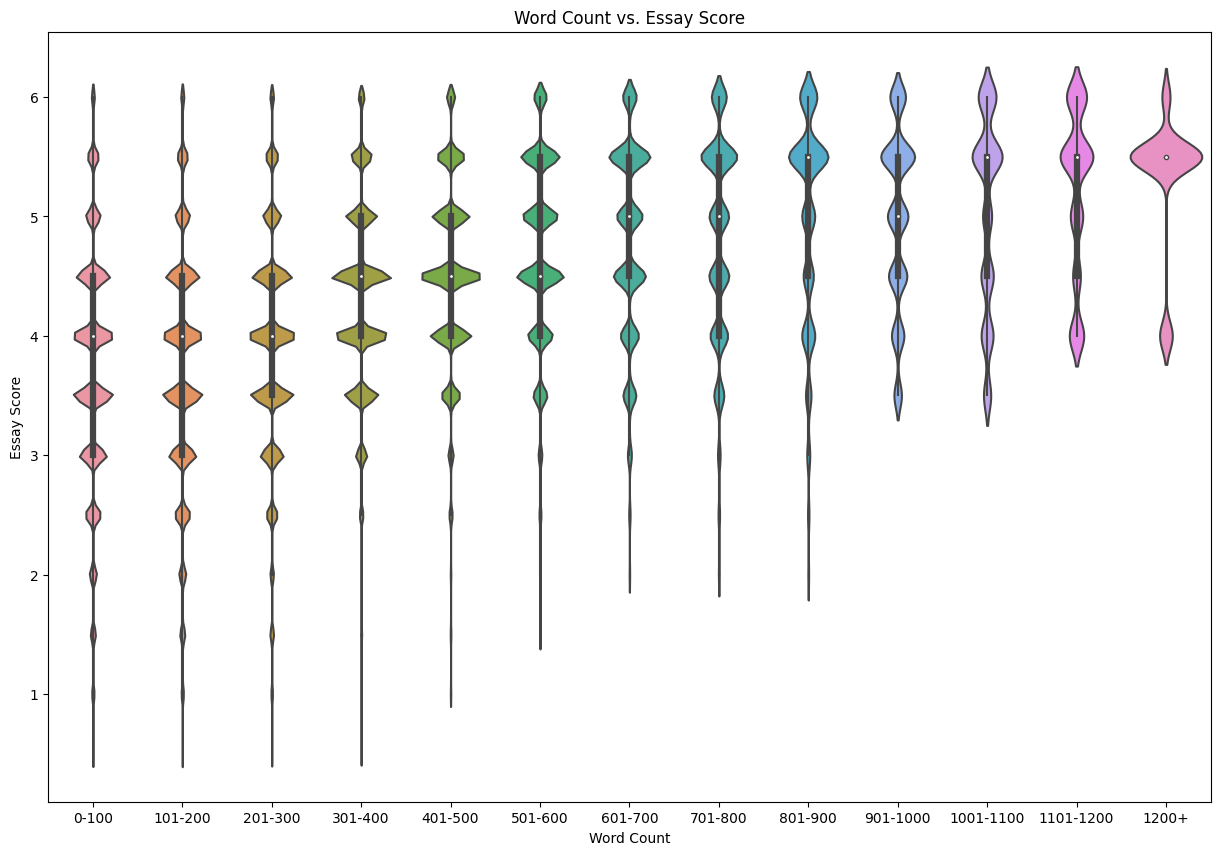

In [76]:
# Word count and essay score violin plot.
merged_data['word_count_category'] = pd.cut(
  merged_data['word_count'],
  bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, float('inf')],
  labels=['0-100', '101-200', '201-300', '301-400', '401-500', '501-600', '601-700', '701-800', '801-900', '901-1000', '1001-1100', '1101-1200', '1200+']
)
# Creating the Violin Plot
plt.figure(figsize=(15, 10))
sns.violinplot(x='word_count_category', y='score', data=merged_data)

# Display plot title and labels
plt.title('Word Count vs. Essay Score')
plt.xlabel('Word Count')
plt.ylabel('Essay Score')

# Display the Violin Plot
plt.show()

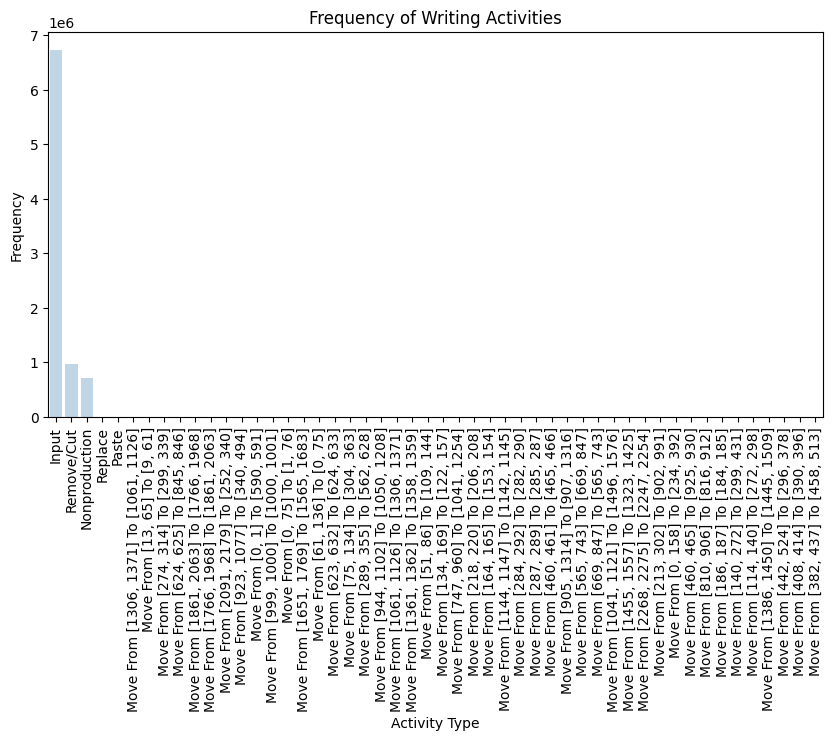

In [77]:
# Calculate the frequency of each active event.
activity_count = merged_data['activity'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=activity_count.index, y=activity_count.values, color=sns.color_palette("Blues")[1])

plt.title('Frequency of Writing Activities')
plt.xlabel('Activity Type')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

plt.show()

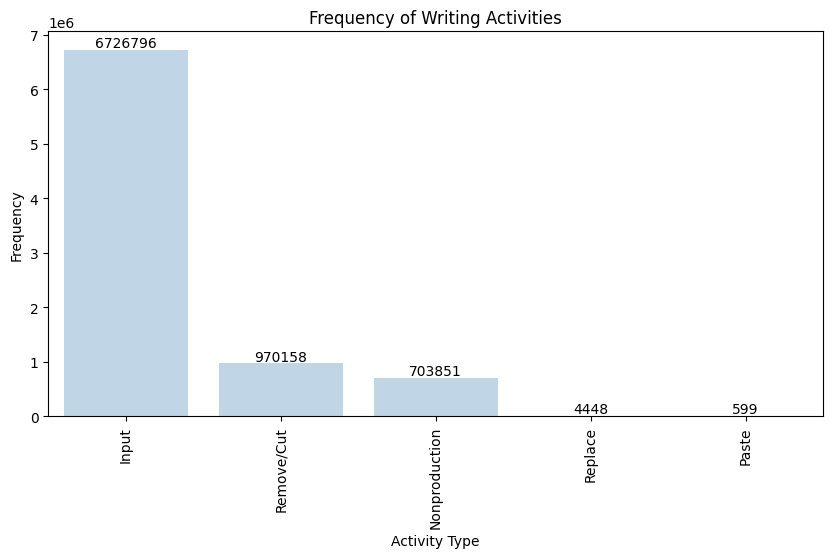

In [78]:
# Filtering out activities that Move From [x1, y1] To [x2, y2]
remove_move = merged_data[~merged_data['activity'].str.startswith('Move')]
Filtered_activity_data = remove_move['activity'].value_counts()

# Calculate the frequency caused by each active event after disregard move behavior
plt.figure(figsize=(10, 5))
barplot = sns.barplot(x=Filtered_activity_data.index, y=Filtered_activity_data.values, color=sns.color_palette("Blues")[1])
# Displaying the number
for activity_num in barplot.patches:
  height = activity_num.get_height()
  barplot.annotate(f'{int(height)}', (activity_num.get_x() + activity_num.get_width() / 2, height), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Frequency of Writing Activities')
plt.xlabel('Activity Type')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

# Displaying the plot
plt.show()

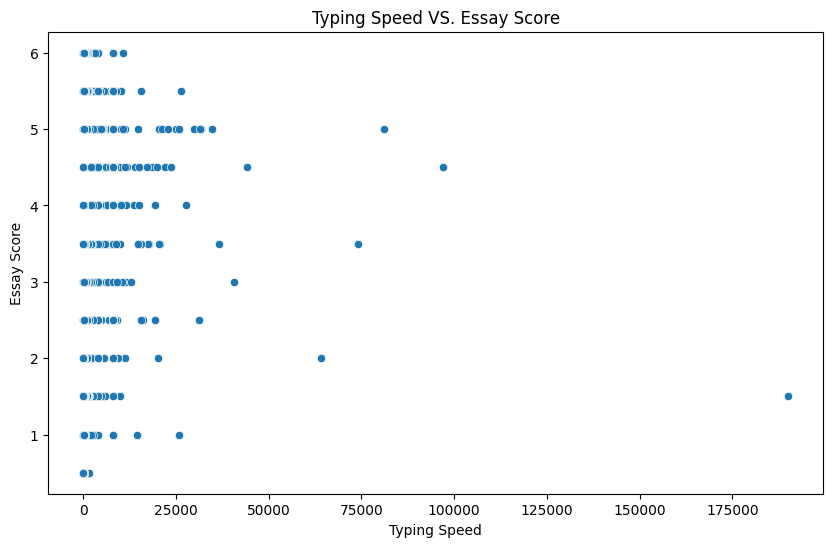

In [79]:
# Analysis the typing speed and essay score
merged_data['text_change_len'] = merged_data['text_change'].apply(len)

merged_data['typing_speed'] = merged_data['text_change_len'] / merged_data['action_time'] * 1000
plt.figure(figsize=(10, 6))
sns.scatterplot(x='typing_speed', y='score', data=merged_data)

# Setting the plot title and axis labels
plt.title('Typing Speed VS. Essay Score')
plt.xlabel('Typing Speed')
plt.ylabel('Essay Score')

# Displaying the plot
plt.show()

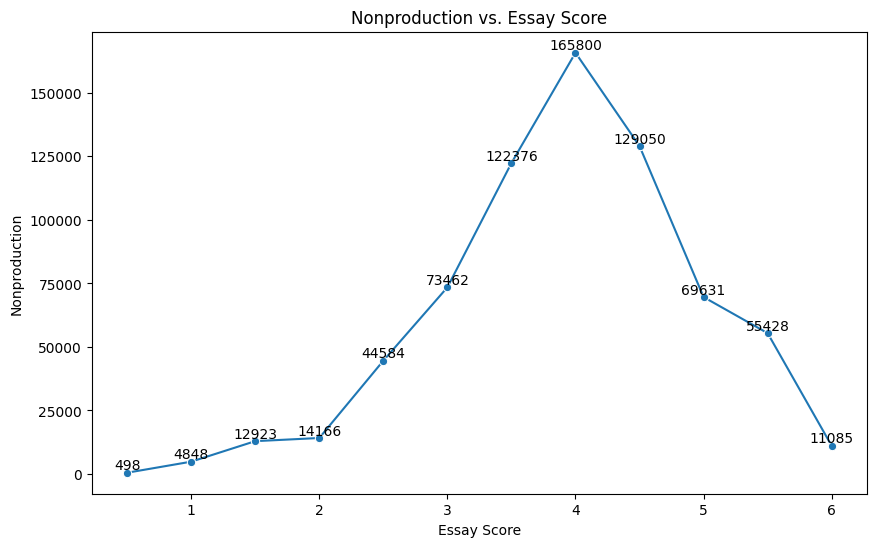

In [80]:
# Analysis the Nonproduction activity and essay score
nonproduction_count = merged_data[merged_data['activity'] == 'Nonproduction']

# Counting Nonproduction activities for each score
nonproduction_score = nonproduction_count.groupby('score').size()

# Creating a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=nonproduction_score.index, y=nonproduction_score.values, marker='o')

# Displaying the count number next to each point
for x, y in zip(nonproduction_score.index, nonproduction_score.values):
  plt.text(x, y, f'{y}', ha='center', va='bottom')

# Setting
plt.xlabel('Essay Score')
plt.ylabel('Nonproduction')
plt.title('Nonproduction vs. Essay Score')

plt.show()

In [89]:
# Creating a Gradient Boosting Regressor Model
merged_data['activity_nonproduction'] = merged_data['activity'] == 'Nonproduction'
# Based on word_count, completion_time, Nonproduction
X = merged_data[['word_count', 'completion_time', 'activity_nonproduction']]
y = merged_data['score']
# Split the valid dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Trainning model
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Prediction on the validation set
y_pred = model.predict(X_val)

# Print result
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"For Score, Mean Squared Error is : {mse}")
print(f"Root Mean Squared Error is : {rmse}")
print(f"R^2 Score is : {r2}")

For Score, Mean Squared Error is : 0.7729759501124108
Root Mean Squared Error is : 0.8791905084294364
R^2 Score is : 0.2137995118348548
